In [1]:
import pandas as pd
import pickle
import numpy as np
#from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [26]:
df_1=pd.read_csv('ED_3hour_forward.csv')

In [27]:
name="label_after_1hour"

In [28]:
#df_1=df_1[~df_1['stay_id'].isin(df_1[df_1[name]==2]['stay_id'].unique())]

In [29]:
df_1.loc[df_1[name] == 1, name] = 0
df_1.loc[df_1[name] == 2, name] = 0
df_1.loc[df_1[name] == 3, name] = 1

In [30]:
from sklearn.model_selection import train_test_split

icu_samples = df_1[df_1[name] == 1]

icu_stay_id = icu_samples['stay_id'].unique()

train_icu_stay_id, icu_temp_stay_id = train_test_split(icu_stay_id, test_size=0.2, random_state=42)
test_icu_stay_id, val_icu_stay_id = train_test_split(icu_temp_stay_id, test_size=0.2, random_state=42)

train_icu_data = df_1[df_1['stay_id'].isin(train_icu_stay_id)]
test_icu_data = df_1[df_1['stay_id'].isin(test_icu_stay_id)]
val_icu_data = df_1[df_1['stay_id'].isin(val_icu_stay_id)]

nor_data=df_1[~df_1['stay_id'].isin(icu_stay_id)]

train_nor_stay_id, nor_temp_stay_id = train_test_split(nor_data['stay_id'].unique(), test_size=0.2, random_state=42)
test_nor_stay_id, val_nor_stay_id = train_test_split(nor_temp_stay_id, test_size=0.2, random_state=42)

train_nor_data = df_1[df_1['stay_id'].isin(train_nor_stay_id)]
test_nor_data = df_1[df_1['stay_id'].isin(test_nor_stay_id)]
val_nor_data = df_1[df_1['stay_id'].isin(val_nor_stay_id)]

train_df = pd.concat([train_icu_data, train_nor_data ])
test_df = pd.concat([test_icu_data, test_nor_data])
val_df = pd.concat([val_icu_data, val_nor_data])

In [31]:
train_df=train_df.sort_index()
test_df=test_df.sort_index()
val_df=val_df.sort_index()

In [32]:
train_df

,stay_id,time,max_temp,max_hr,max_resp,max_o2sat,max_sbp,max_dbp,min_temp,min_hr,...,label_after_6hour,gender_F,gender_M,race_Black,race_Other,race_White,arrival_transport_AMBULANCE,arrival_transport_HELICOPTER,arrival_transport_OTHER,arrival_transport_WALK IN
24,30000038.0,2152-12-07 17:37:00,-1.175465,-1.718244,-0.016748,-1.697931,0.380412,-0.267223,-1.17796,-1.656226,...,2.0,0.876349,-0.876349,-0.526599,-0.481254,0.825292,1.242434,-0.0278,-0.110842,-1.209452
25,30000038.0,2152-12-07 18:37:00,-1.175465,-1.718244,-0.016748,-1.697931,0.380412,-0.267223,-1.17796,-1.656226,...,2.0,0.876349,-0.876349,-0.526599,-0.481254,0.825292,1.242434,-0.0278,-0.110842,-1.209452
26,30000038.0,2152-12-07 19:37:00,-1.175465,-0.348524,0.659705,-1.201637,0.380412,-0.267223,-1.17796,-1.656226,...,2.0,0.876349,-0.876349,-0.526599,-0.481254,0.825292,1.242434,-0.0278,-0.110842,-1.209452
27,30000038.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
28,30000038.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7149115,39999933.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
7149116,39999933.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
7149117,39999933.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
7149118,39999933.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000


In [33]:
print(len(train_df['stay_id'].unique()))
print(len(test_df['stay_id'].unique()))
print(len(val_df['stay_id'].unique()))

238304
47661
11916


In [34]:
train_x=train_df.drop(['stay_id','time','label_after_1hour','label_after_2hour','label_after_3hour','label_after_4hour','label_after_5hour','label_after_6hour'],axis='columns')
train_y=train_df[name]
test_x=test_df.drop(['stay_id','time','label_after_1hour','label_after_2hour','label_after_3hour','label_after_4hour','label_after_5hour','label_after_6hour'],axis='columns')
test_y=test_df[name]
val_x=val_df.drop(['stay_id','time','label_after_1hour','label_after_2hour','label_after_3hour','label_after_4hour','label_after_5hour','label_after_6hour'],axis='columns')
val_y=val_df[name]

In [35]:
train_x = train_x.astype(np.float32)
train_y = train_y.astype(np.float32)
test_x = test_x.astype(np.float32)
test_y = test_y.astype(np.float32)
val_x = val_x.astype(np.float32)
val_y = val_y.astype(np.float32)
train_x = train_x.to_numpy()
train_y = train_y.to_numpy()
test_x = test_x.to_numpy()
test_y = test_y.to_numpy()
val_x = val_x.to_numpy()
val_y = val_y.to_numpy()
train_data_x_reshaped = train_x.reshape((len(train_df['stay_id'].unique()), 24, 114))
train_data_y_reshaped = train_y.reshape((len(train_df['stay_id'].unique()), 24,1))
test_data_x_reshaped = test_x.reshape((len(test_df['stay_id'].unique()), 24, 114))
test_data_y_reshaped = test_y.reshape((len(test_df['stay_id'].unique()), 24, 1))
val_x_reshaped = val_x.reshape((len(val_df['stay_id'].unique()), 24, 114))
val_y_reshaped = val_y.reshape((len(val_df['stay_id'].unique()), 24, 1))

In [36]:
train_data_y_reshaped.shape

(238304, 24, 1)

In [37]:
train_data_y_reshaped[0].shape

(24, 1)

In [38]:
largest_values = np.max(train_data_y_reshaped, axis=1, keepdims=True) 
train_data_y_reshaped_1 = largest_values.reshape(len(train_df['stay_id'].unique()), 1, 1)

largest_values = np.max(test_data_y_reshaped, axis=1, keepdims=True) 
test_data_y_reshaped_1 = largest_values.reshape(len(test_df['stay_id'].unique()), 1, 1)

largest_values = np.max(val_y_reshaped, axis=1, keepdims=True) 
val_y_reshaped_1 = largest_values.reshape(len(val_df['stay_id'].unique()), 1, 1)

In [39]:
train_data_y_reshaped_1[0]

array([[0.]], dtype=float32)

In [40]:
train_dataset = TensorDataset(torch.tensor(train_data_x_reshaped),torch.tensor(train_data_y_reshaped_1)) 
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True) 

valid_dataset = TensorDataset(torch.tensor(val_x_reshaped),torch.tensor(val_y_reshaped_1))
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

test_dataset = TensorDataset(torch.tensor(test_data_x_reshaped),torch.tensor(test_data_y_reshaped_1)) 
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False) 

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [42]:
sequence_length = 24 # 
feature_size = 114 # 
hidden_size = 256 # Hidden Layer 사이즈 설정처럼 설정
num_layers = 4 # stacked RNN (최대 4개까지는 Gradient Vanishing 현상이 적을 수 있으므로)
dropout_p = 0.3 # dropout rate
output_size = 1 # 
#minibatch_size = 128 # minibatch_size

In [43]:
class Net(nn.Module):
    def __init__(self, feature_size, hidden_size, num_layers, dropout_p, output_size, model_type):
        super().__init__()
        if model_type == 'rnn':
            self.sequenceclassifier = nn.RNN(
                input_size = feature_size,
                hidden_size = hidden_size,
                num_layers = num_layers,
                batch_first = True,
                dropout = dropout_p,
                bidirectional = True
            )
        elif model_type == 'lstm':
            self.sequenceclassifier = nn.LSTM(
                input_size = feature_size,
                hidden_size = hidden_size,
                num_layers = num_layers,
                batch_first = True,
                dropout = dropout_p,
                bidirectional = True
            )
        self.layers = nn.Sequential(
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(hidden_size * 2*24),
            # self.rnn() 의 출력값은 (batch_size, sequence_length, bidirections * hidden_size)
            # bidirectional 이 True 이므로, bidirections 는 2, 즉 2 * hidden_size
            nn.Linear(hidden_size * 2*24, output_size),
            nn.Sigmoid() 
            #nn.LogSoftmax(dim=-1)
        )

    def forward(self, x):
        # |x| = batch_first=True 이므로 (batch_size, sequence_length, input_size)
        out, _ = self.sequenceclassifier(x) # output, h_n 이므로, h_n 은 사용안함
        # output, h_n 이므로, h_n 은 사용안함
        # |out| = batch_first=True 이므로 (batch_size, sequence_length, 2 * hidden_size)
        # bidirectional 이 True 이면, bidirections 는 2 * hidden_size
        #print(out.shape)
        out = out.reshape(out.size(0), -1)
        #print(out.shape)
        # out[:, -1] 은 (batch_size, sequence_length, 2 * hidden_size) 에서, 
        # 전체 batch_size 를 선택한다는 의미가 :, 
        # sequence_length 인 28개의 순서가 있고, 각 순서마다 2 * hidden_size 만큼 있음
        # 이중에 최종 값은 맨 마지막  sequence_length 의 2 * hidden_size 임
        # |out| = (batch_size, hidden_size * 2)
        y = self.layers(out)
        # |y| = (batch_size, output_size)
        return y

In [44]:
model = Net(feature_size, hidden_size, num_layers, dropout_p, output_size, 'lstm').to(device)
model

Net(
  (sequenceclassifier): LSTM(114, 256, num_layers=4, batch_first=True, dropout=0.3, bidirectional=True)
  (layers): Sequential(
    (0): LeakyReLU(negative_slope=0.1)
    (1): BatchNorm1d(12288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=12288, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [45]:
from copy import deepcopy

#loss_func = F.binary_cross_entropy() # log softmax 는 NLLLoss() 로 진행해야 함
optimizer = torch.optim.Adam(model.parameters()) # Adam, learning rate 필요없음

def train_model(model, early_stop, n_epochs, progress_interval):
    
    train_losses, valid_losses, lowest_loss = list(), list(), np.inf

    for epoch in range(n_epochs):
        
        train_loss, valid_loss = 0, 0
        
        # train the model
        model.train() # prep model for training
        for x_minibatch, y_minibatch in train_dataloader:
            x_minibatch, y_minibatch = x_minibatch.to(device), y_minibatch.to(device) 
            y_minibatch_pred = model(x_minibatch)
            true_y = y_minibatch[:, 0]
            loss = F.binary_cross_entropy(y_minibatch_pred , true_y )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_dataloader)
        train_losses.append(train_loss)      
        
        # validate the model
        model.eval()
        with torch.no_grad():
            for x_minibatch, y_minibatch in valid_dataloader:
                x_minibatch, y_minibatch = x_minibatch.to(device), y_minibatch.to(device) 
                y_minibatch_pred = model(x_minibatch)
                true_y = y_minibatch[:, 0]
                loss = F.binary_cross_entropy(y_minibatch_pred , true_y )
                #loss = loss_func(y_minibatch_pred , y_minibatch )
                valid_loss += loss.item()
                
        valid_loss = valid_loss / len(valid_dataloader)
        valid_losses.append(valid_loss)

        if valid_losses[-1] < lowest_loss:
            lowest_loss = valid_losses[-1]
            lowest_epoch = epoch
            best_model = deepcopy(model.state_dict())
        else:
            if (early_stop > 0) and lowest_epoch + early_stop < epoch:
                print ("Early Stopped", epoch, "epochs")
                break
                
        if (epoch % progress_interval) == 0:
            print (train_losses[-1], valid_losses[-1], lowest_loss, lowest_epoch, epoch)
            
    model.load_state_dict(best_model)        
    return model, lowest_loss, train_losses, valid_losses

nb_epochs = 1000
progress_interval = 3
early_stop = 30

model, lowest_loss, train_losses, valid_losses = train_model(model, early_stop, nb_epochs, progress_interval)

0.11718523548565861 0.09532626140169165 0.09532626140169165 0 0
0.08407691175420193 0.08431147654203976 0.08431147654203976 3 3
0.0742474691197076 0.08955786943911238 0.08431147654203976 3 6
0.05395257091709882 0.0998444142553242 0.08431147654203976 3 9
0.03842651040808955 0.12556487575490424 0.08431147654203976 3 12
0.02954622162334675 0.12458721920847893 0.08431147654203976 3 15
0.023452959739273364 0.13188143953324316 0.08431147654203976 3 18
0.01919411475167842 0.16347773187853237 0.08431147654203976 3 21
0.016187393056284027 0.17251400260299327 0.08431147654203976 3 24
0.013795887168217563 0.17386220867170932 0.08431147654203976 3 27
0.012581449175829897 0.19579874139596173 0.08431147654203976 3 30
0.0117293684967524 0.15839614861823142 0.08431147654203976 3 33
Early Stopped 34 epochs


In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_auc_score, average_precision_score
from tqdm import tqdm

# ...

# Assuming you have a test_dataloader for your test data
#test_loss = test_model(model, test_dataloader)
#print(f'Test Loss: {test_loss}')

# Evaluate additional metrics
model.eval()
all_true_labels = []
all_pred_probs = []

with torch.no_grad():
    for x_minibatch, y_minibatch in tqdm(test_dataloader):
        x_minibatch, y_minibatch = x_minibatch.to(device), y_minibatch.to(device) 
        y_minibatch_pred = model(x_minibatch)
        true_y = y_minibatch[:, 0].cpu().numpy().astype(int)
        pred_probs = y_minibatch_pred.cpu().numpy()

        all_true_labels.extend(true_y)
        all_pred_probs.extend(pred_probs.flatten())

# Convert probabilities to binary predictions using a threshold (e.g., 0.4)
threshold = 0.30
all_pred_labels = (np.array(all_pred_probs) > threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(all_true_labels, all_pred_labels)
precision = precision_score(all_true_labels, all_pred_labels)
recall = recall_score(all_true_labels, all_pred_labels)
conf_matrix = confusion_matrix(all_true_labels, all_pred_labels)

# Calculate AUROC and AUPRC
auroc = roc_auc_score(all_true_labels, all_pred_probs)
auprc = average_precision_score(all_true_labels, all_pred_probs)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'AUROC: {auroc}')
print(f'AUPRC: {auprc}')


100%|██████████| 373/373 [00:04<00:00, 91.72it/s] 


Accuracy: 0.9667023352426513
Precision: 0.5287958115183246
Recall: 0.4248798076923077
Confusion Matrix:
[[45367   630]
 [  957   707]]
AUROC: 0.9399657818925481
AUPRC: 0.4687344433993684


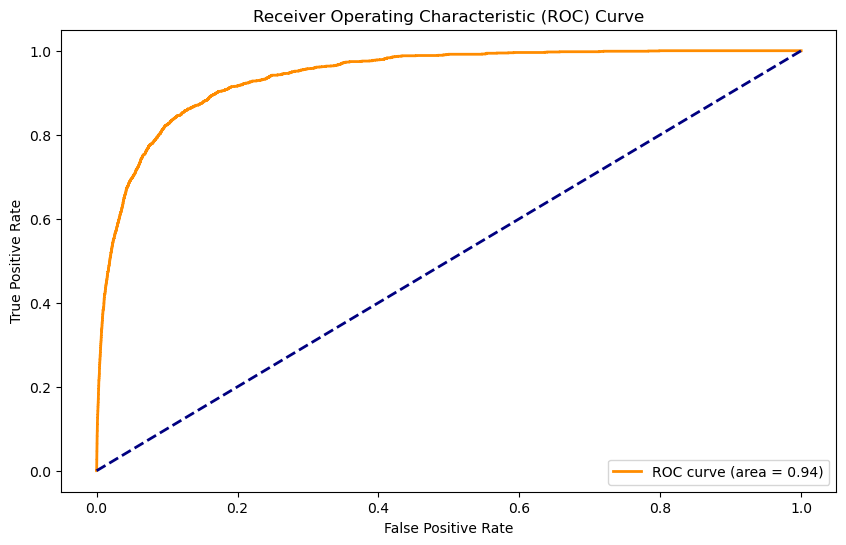

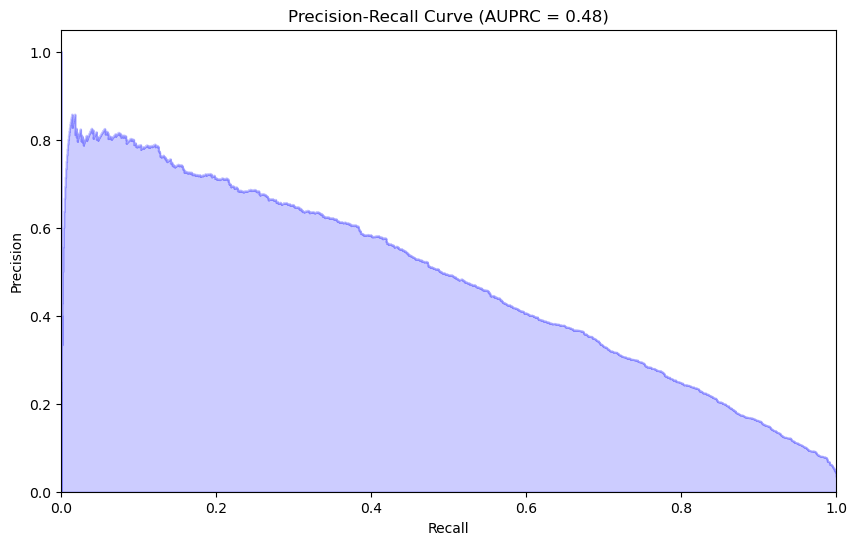

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# ROC Curve
fpr, tpr, _ = roc_curve(all_true_labels, all_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_true_labels, all_pred_probs)
auprc = average_precision_score(all_true_labels, all_pred_probs)

plt.figure(figsize=(10, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AUPRC = {:.2f})'.format(auprc))
plt.show()


In [3]:
import torch
import torch.nn as nn

# Example predicted and target values
predicted = torch.tensor([1.0, 3.0, 3.0])
target = torch.tensor([2.0, 2.0, 3.0])

# Instantiate the L1Loss with 'sum' reduction
criterion = nn.L1Loss(reduction='sum')

# Calculate the loss
loss = criterion((predicted*mask)/mask.sum(), (target*mask)/mask.sum())

print("Total L1 Loss:", loss.item())

Total L1 Loss: 0.5


In [2]:
mask=[1,0,1]
mask=torch.tensor(mask)

In [54]:
mask.sum()

tensor(2)

In [13]:
import torch
import torch.nn as nn

# Example predicted and target values
predicted = torch.tensor([[[1.0, 3.0, 3.0],[1,2,4]]])
target = torch.tensor([[2.0, 2.0, 3.0],[1,3,5]])

# Instantiate the L1Loss with 'sum' reduction
criterion = nn.L1Loss(reduction='sum')

# Calculate the loss
loss = criterion(predicted*mask ,target*mask)
loss= loss/mask.sum()


print("Total L1 Loss:", loss.item())

Total L1 Loss: 1.0


C:\Users\DAHS\AppData\Local\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([2, 3])) that is different to the input size (torch.Size([1, 2, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [25]:
torch.sum(predicted, axis = 1, keepdim=True)#.reshape(2,1)

tensor([[[2., 5., 7.]]])

In [14]:
predicted.

torch.Size([1, 2, 3])

In [15]:
target.shape

torch.Size([2, 3])